In [917]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.feature_extraction import FeatureHasher
from kmodes.kprototypes import KPrototypes


In [918]:
ratings = pd.read_csv('../datasets/ml-100k/u.data', 
                      sep='\t', 
                      names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings = ratings.drop(columns='timestamp')

user_item_dense = ratings.pivot(
    index='user_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [919]:
user = pd.read_csv('../datasets/ml-100k/u.user', 
                      sep='|', 
                      names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

merged = user.merge(user_item_dense, on='user_id')

user

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [920]:
# 2. One-Hot Encoding sulle colonne categoriche (gender, occupation, zip_code)
#user_encoded = pd.get_dummies(user, columns=['gender', 'occupation', 'zip_code'])
#data_for_clustering.columns = data_for_clustering.columns.astype(str)


In [921]:
#LABEL ENCODER

le_gender = LabelEncoder()
le_occ = LabelEncoder()
le_zip = LabelEncoder()
user['gender_le'] = le_gender.fit_transform(user['gender'])
user['occupation_le'] = le_occ.fit_transform(user['occupation'])
user['zip_le'] = le_zip.fit_transform(user['zip_code'])
df_le = user[['user_id','age','gender_le','occupation_le', 'zip_le']]
#df_le

In [922]:
#BINARY ENCODER
be = BinaryEncoder(cols=['gender','occupation','zip_code'], return_df=True)
df_be = be.fit_transform(user[['user_id','age', 'gender','occupation','zip_code']])
#df_be

In [923]:
#HASHER 
user_dicts = user[['gender', 'occupation', 'zip_code']].astype(str).to_dict(orient='records')

# 2. Hasher con input_type='dict'
hasher = FeatureHasher(n_features=10, input_type='dict')
hashed = hasher.transform(user_dicts)

# 3. Converti in DataFrame
df_hash = pd.DataFrame(hashed.toarray(), columns=[f"hash_{i}" for i in range(10)])


In [924]:
#TARGET ENCODER

te = TargetEncoder(cols=['gender', 'occupation', 'zip_code'])
df_te = te.fit_transform(user[['gender', 'occupation', 'zip_code']], user['age'])
df_te['age'] = user['age']
df_te


,gender,occupation,zip_code,age
0,34.149254,33.448045,33.689963,24
1,33.813187,34.523714,34.867750,53
2,34.149254,36.139736,32.614008,23
3,34.149254,33.448045,32.744116,24
4,33.813187,34.523714,33.915093,33
...,...,...,...,...
938,33.813187,22.081633,33.004333,26
939,34.149254,38.734009,32.602260,32
940,34.149254,22.081633,32.223683,20
941,33.813187,39.743596,35.866720,48


In [925]:
print(df_be['zip_code_1'].dtype)

int64


In [926]:
# 3. Rimuovi l'ID utente (non utile per clustering)
#data_for_clustering = df_be.drop(columns=['user_id'])
data_for_clustering = df_te
data_for_clustering

,gender,occupation,zip_code,age
0,34.149254,33.448045,33.689963,24
1,33.813187,34.523714,34.867750,53
2,34.149254,36.139736,32.614008,23
3,34.149254,33.448045,32.744116,24
4,33.813187,34.523714,33.915093,33
...,...,...,...,...
938,33.813187,22.081633,33.004333,26
939,34.149254,38.734009,32.602260,32
940,34.149254,22.081633,32.223683,20
941,33.813187,39.743596,35.866720,48


In [927]:
# 4. Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

In [928]:

# 5. Trova il numero ottimale di cluster usando il silhouette score
silhouette_scores = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Numero ottimale di cluster trovato: {optimal_k} | ")


Numero ottimale di cluster trovato: 5 | 


/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/li

In [929]:
opt = silhouette_scores.index(max(silhouette_scores))
silhouette_scores[opt]

0.4675826808445084

In [930]:
opt

3

In [931]:
silhouette_scores

[0.3423728308621057,
 0.3833989601718213,
 0.4596173332013154,
 0.4675826808445084,
 0.43377588335964945,
 0.3779916261489586,
 0.46527436329721894,
 0.4394728023474113,
 0.3980928494099358]

In [932]:
# 6. Applica KMeans con il numero ottimale di cluster
kmeans = KMeans(n_clusters=opt, random_state=42)
user['cluster'] = kmeans.fit_predict(data_scaled)

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning:

invalid value encountered in matmul



In [933]:
pca = PCA(n_components=3)
components = pca.fit_transform(data_scaled)
user[['PCA1','PCA2','PCA3']] = components


/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/FDSML/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul



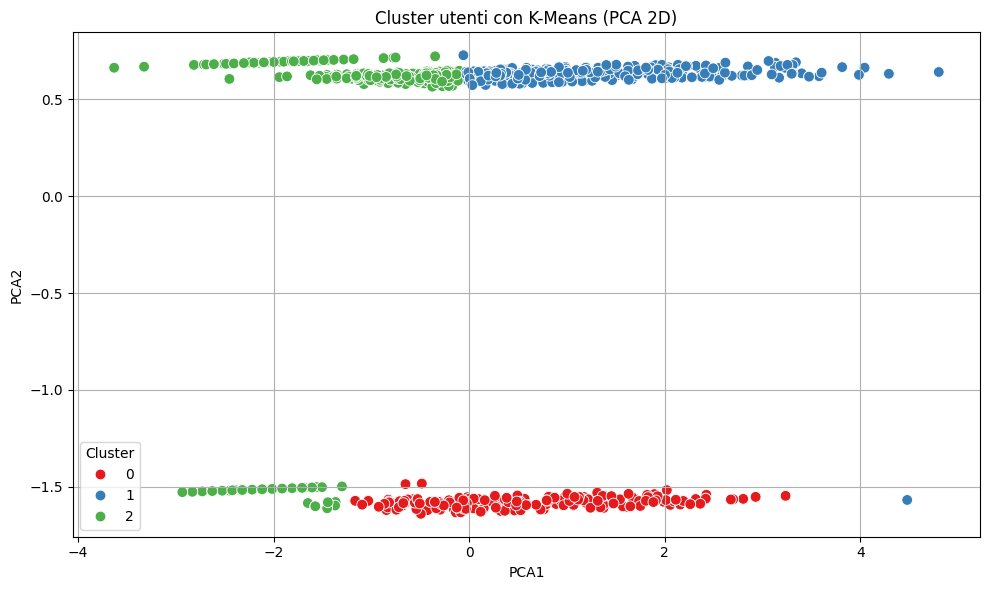

In [934]:
# 8. Plot dei cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user, x='PCA1', y='PCA2', hue='cluster', palette='Set1', s=60)
plt.title('Cluster utenti con K-Means (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [935]:
import plotly.express as px

# Sostituisci questa parte con il tuo caricamento del DataFrame
# import pandas as pd
# user = pd.read_csv('tuo_file.csv')

fig = px.scatter_3d(
    user,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='cluster',
    title='Cluster utenti con K-Means (PCA 3D)',
    labels={'PCA1': 'PCA1', 'PCA2': 'PCA2', 'PCA3': 'PCA3'}
)

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title_text='Cluster'
)

fig.show()
